Notebook to investigate how the IRFs change with different parameter values

# Imports

In [105]:
%load_ext autoreload
%autoreload 2

import os
import datetime
import sys

from HANKStickyModel import HANKStickyModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Settings

In [106]:
# settings

# save
save_models = False

# paths
path_savefolder = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'saved_models')  # save folder for models
path_images = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + 'images' + os.sep + 'parameter_sensitivity') # save folder for images

# model settings
baseline_inattention = 0.935 # baseline setting for inattention

shock_baseline = {'jump_eg': 0.0001,
                  'rho_eg': 0.6,
                  'jump_em': 0.0}

updated_par_base = {**{'inattention': baseline_inattention}, **shock_baseline} # update parameters used for all models


# init
models = {}
models_solved = {}
model_labels = {}

In [107]:
# paths to plot
paths = ['G', 'Y', 'C_hh', 'L_hh', 'A_hh', 'K', 'I', 'Z',
         'N', 'w', 'tau', 'Pi', 'i', 'r',
         'qB', 'p_eq', 'Div']
paths_short = ['Y', 'C_hh', 'K', 'I', 'N', 'w']
lvl_value = ['eg', 'em', 'ez', 'i', 'Pi', 'Pi_w']
abs_diff = ['r', 'ra', 'rl', 'i']
facs = {'r':100,'ra':100,'rl':100, 'i':100}

In [108]:
def solution_routine_comparison_no_sticky(models, compare_models, models_solved={}):
    """ solve models and store in list

        :param models: dictionary of models with model parameter settings
        :param compare_models: list of model names from models dictionary to compare
        :param models_solved dictionary with solved models"""

    update_par = {
        'inattention': 0.0
    }

    # init container for models
    for m in compare_models:
        # init model
        print('\r'+f' -------- Model: {m} ---------')

        updated_par_temp = {**updated_par_base, **models[m], **{'inattention': 0.0}} # if inattention parameter in **models[m]['update_par'], the value gets overwritten

        models_solved[m] = HANKStickyModelClass(name=m, par=updated_par_temp, savefolder=path_savefolder)
        # solve model
        print("\r"+'Find steady state  ',end="")
        models_solved[m].find_ss(do_print=False)
        print("\r"+'Compute Jacobians  ',end="")
        models_solved[m].compute_jacs(do_print=False)
        print("\r"+'Find transition path',end="")
        models_solved[m].find_transition_path(do_print=False, do_print_unknowns=False)
        print("\r"+'Find IRFs           ',end="")
        models_solved[m].find_IRFs(do_print=False)

        if save_models:
            m_name = m + f'_{datetime.datetime.now().strftime("%m_%d")}'
            models_solved[m].name = m_name
            models_solved[m].save()

            print("\r"+f'saved {m_name}')

    return models_solved

def get_sticky_IRFs(compare_models, models_solved=[], inattention = 0.935):
    """ get sticky information IRFs for list of models"""

    for m in compare_models:
        m_sticky = f"{m}_sticky"

        print('\r'+f' -------- Model: {m_sticky} ---------')

        models_solved[m_sticky] = models_solved[m].copy()

        models_solved[m_sticky].par.inattention = inattention

        print("\r"+'Compute Jacobians',end="")
        models_solved[m_sticky].compute_jacs(do_print=False)
        print("\r"+'Find transition path',end="")
        models_solved[m_sticky].find_transition_path(do_print=False, do_print_unknowns=False)
        print("\r"+'Find IRFs',end="")
        models_solved[m_sticky].find_IRFs(do_print=False)

    print("\r"+'                  ',end="")

    return models_solved

Things to include:
1. Different spending types
2. Different shock trajectories
3. Different rigidity parameters
   - Fiscal multiplier based on output being demand determined. Partial equilibrium logic from Hagedorn: "... ensures that the increase in government spending stimulates aggregate demand in the first place. The typical underlying assumption is that prices are rigid so that firms adjust quantities and not only prices in response to increased government demand. Firms increase production to satisfy this demand by raising employment, capital and wages, which leads to higher household income."
   - Analysis about the multiplier " This requires a model that, first, features the right amount of nominal rigidities, so that the aggregate demand channel is as in the data"

4. Different MP reactions
5. Different inattention levels
6. MPC's
    - "Important to also look at how MPCs change, because: " significant deviation from the permanent income hypothesis, such that households have a high marginal propensity to consume (MPC) out of the transitory increase in income induced by the stimulus, generating a nontrivial indirect effect.  Higher private consumption directly induced by government spending then leads to further increase in labor demand, income, consumption and so on."
     - Analysis about fiscal multiplier  "requires incorporating observed marginal propensities to consume that imply a substantial deviation from the permanent income hypothesis"
7. FP shock persistence (big focus in "The intertemporal keynesian cross" paper.


# Spending types
Compare responses of

1. a purely tax financed shock
2. a purely deficit financed shock
3. a shock that is financed by increased taxes and deficit

In [109]:
models['tax_financing'] = {
    'phi_G': 1.0
}

models['mixed_financing'] = {
    'phi_G': 0.5
}

models['deficit_financing'] = {
    'phi_G': 0.0
}

In [110]:
compare_models = ['tax_financing', 'deficit_financing', 'mixed_financing']
models_solved = solution_routine_comparison_no_sticky(models, compare_models, models_solved)
models_solved = get_sticky_IRFs(compare_models, models_solved, inattention = baseline_inattention)

 -------- Model: tax_financing ---------
saved tax_financing_01_04 with size 48 Bytes
 -------- Model: deficit_financing ---------
saved deficit_financing_01_04 with size 48 Bytes
 -------- Model: mixed_financing ---------
saved mixed_financing_01_04 with size 48 Bytes


### shocks ###


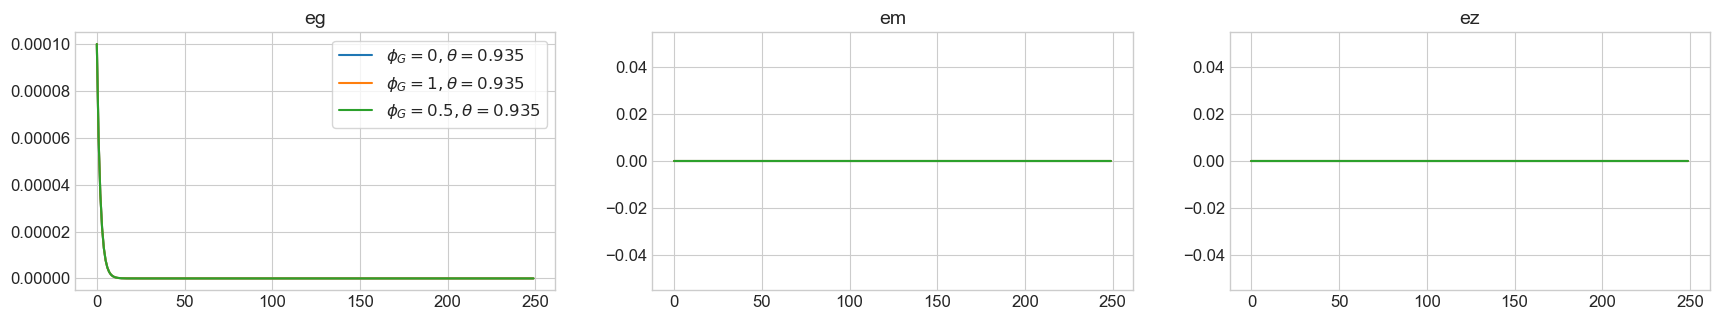


### varnames ###


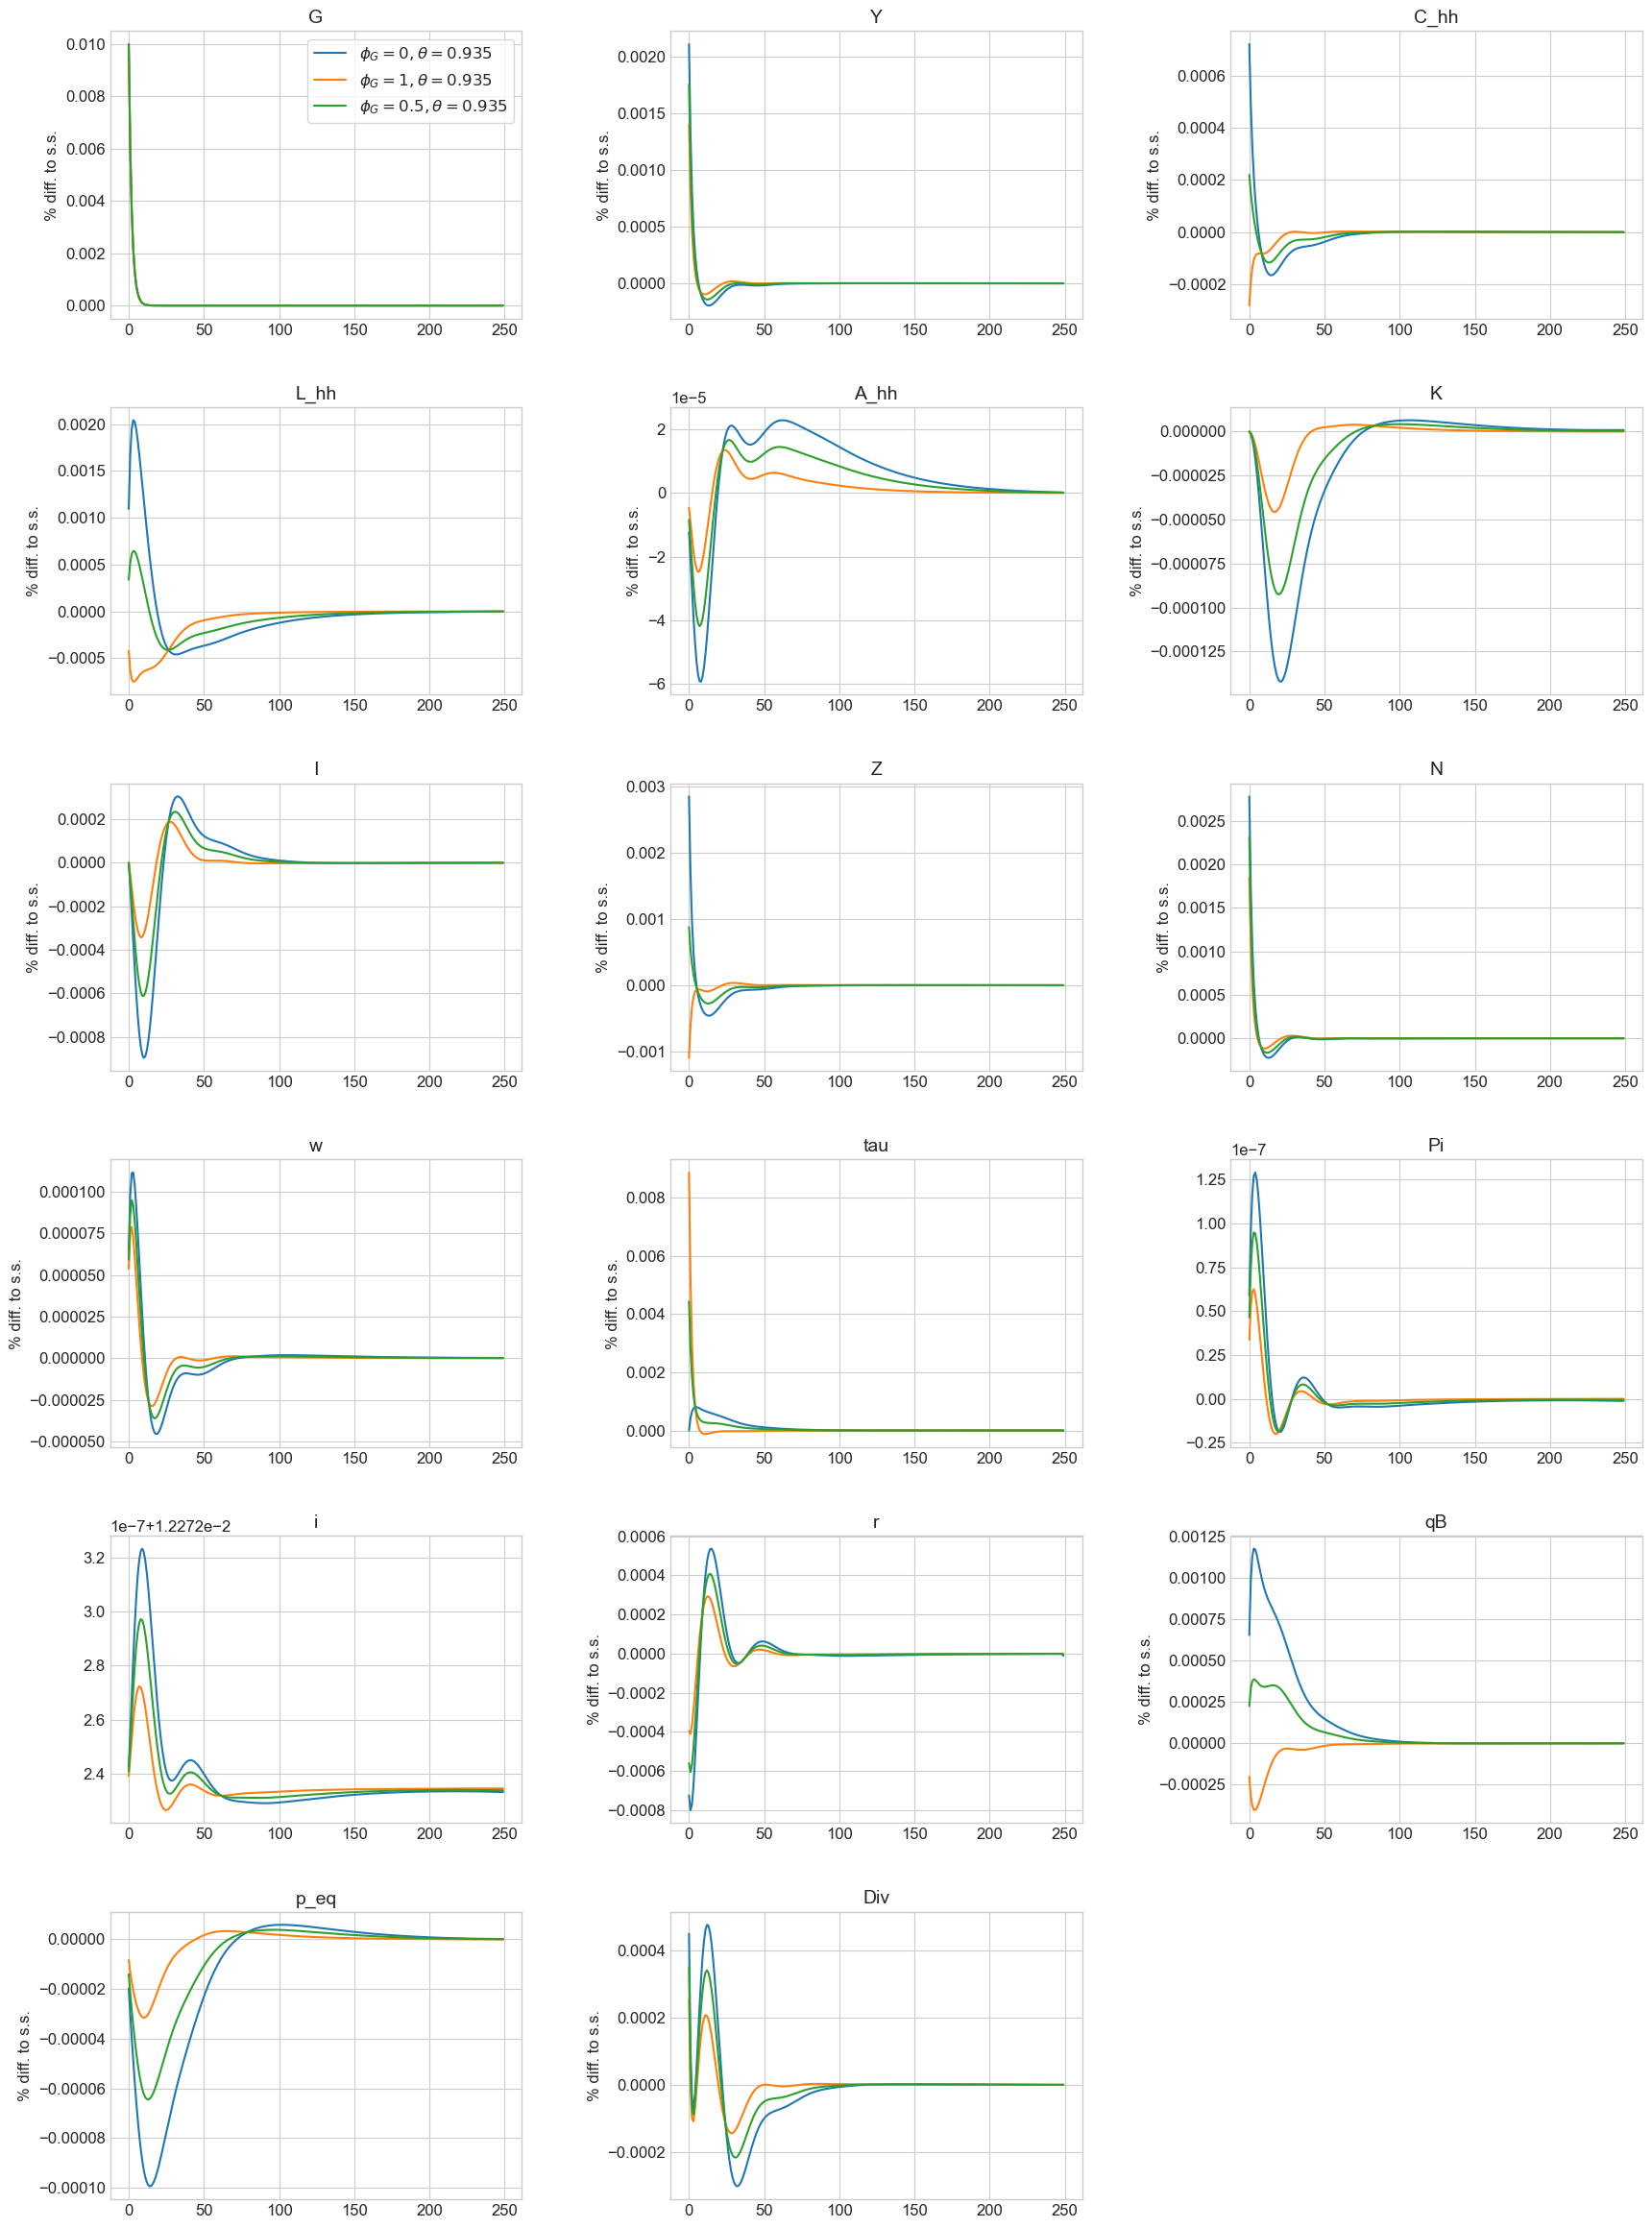

In [113]:
compare_models = ['tax_financing_sticky', 'deficit_financing_sticky', 'mixed_financing_sticky']
labels = [f'$\phi_G = 0, \\theta = {baseline_inattention}$', f'$\phi_G = 1, \\theta = {baseline_inattention}$', f'$\phi_G = 0.5, \\theta = {baseline_inattention}$']
models_list = [models_solved[m] for m in compare_models]
models_solved['tax_financing'].compare_IRFs(models_list, labels, paths, lvl_value=lvl_value, do_shocks=True, do_targets=False, ncols=3)

## Tax rate responsivness

For a deficit financed shock, the speed of adjustment of the tax rate can differ.
If the tax rate does not adjust, there is no convergence to the old steady state with the previous debt ratio.

In [109]:
models['deficit_financing_phi_tau_005'] = {
    'phi_G': 0.0,
    'phi_tau': 0.05
}
models['deficit_financing_phi_tau_02'] = {
    'phi_G': 0.0,
    'phi_tau': 0.2
}

In [116]:
test = {'a': 'a',
        'b': 'b',
        'c': 'c'}
print(test)

[test.pop(key) for key in ['a', 'b']]

print(test)

{'a': 'a', 'b': 'b', 'c': 'c'}
{'c': 'c'}


In [110]:
compare_models = ['deficit_financing', 'deficit_financing_phi_tau_005', 'deficit_financing_phi_tau_02']
models_solved = solution_routine_comparison_no_sticky(models, compare_models, models_solved)
models_solved = get_sticky_IRFs(compare_models, models_solved, inattention = baseline_inattention)
# delete no sticky models to save memory
[models_solved.pop(key) for key in ['deficit_financing_phi_tau_005', 'deficit_financing_phi_tau_02']]

 -------- Model: tax_financing ---------
saved tax_financing_01_04 with size 48 Bytes
 -------- Model: deficit_financing ---------
saved deficit_financing_01_04 with size 48 Bytes
 -------- Model: mixed_financing ---------
saved mixed_financing_01_04 with size 48 Bytes


### shocks ###


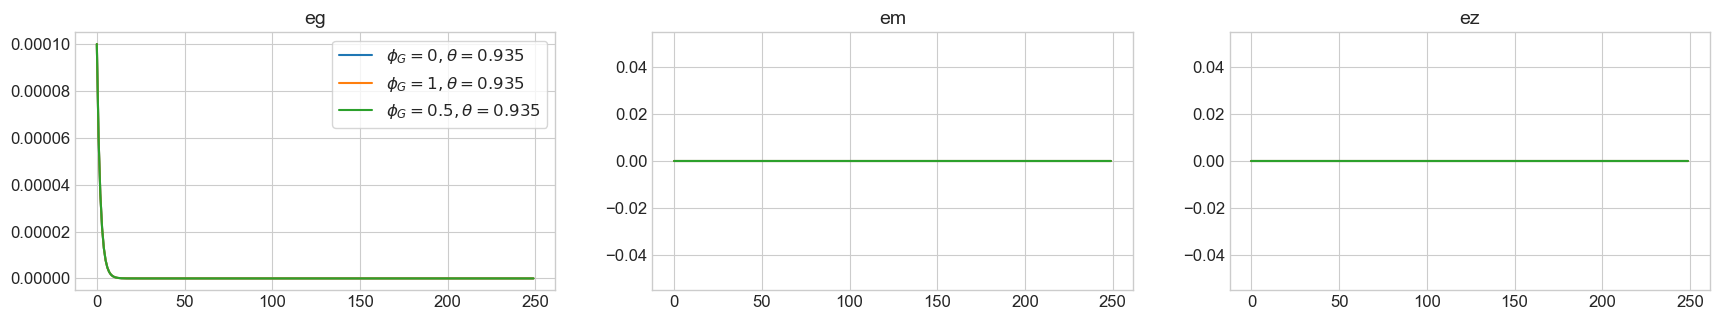


### varnames ###


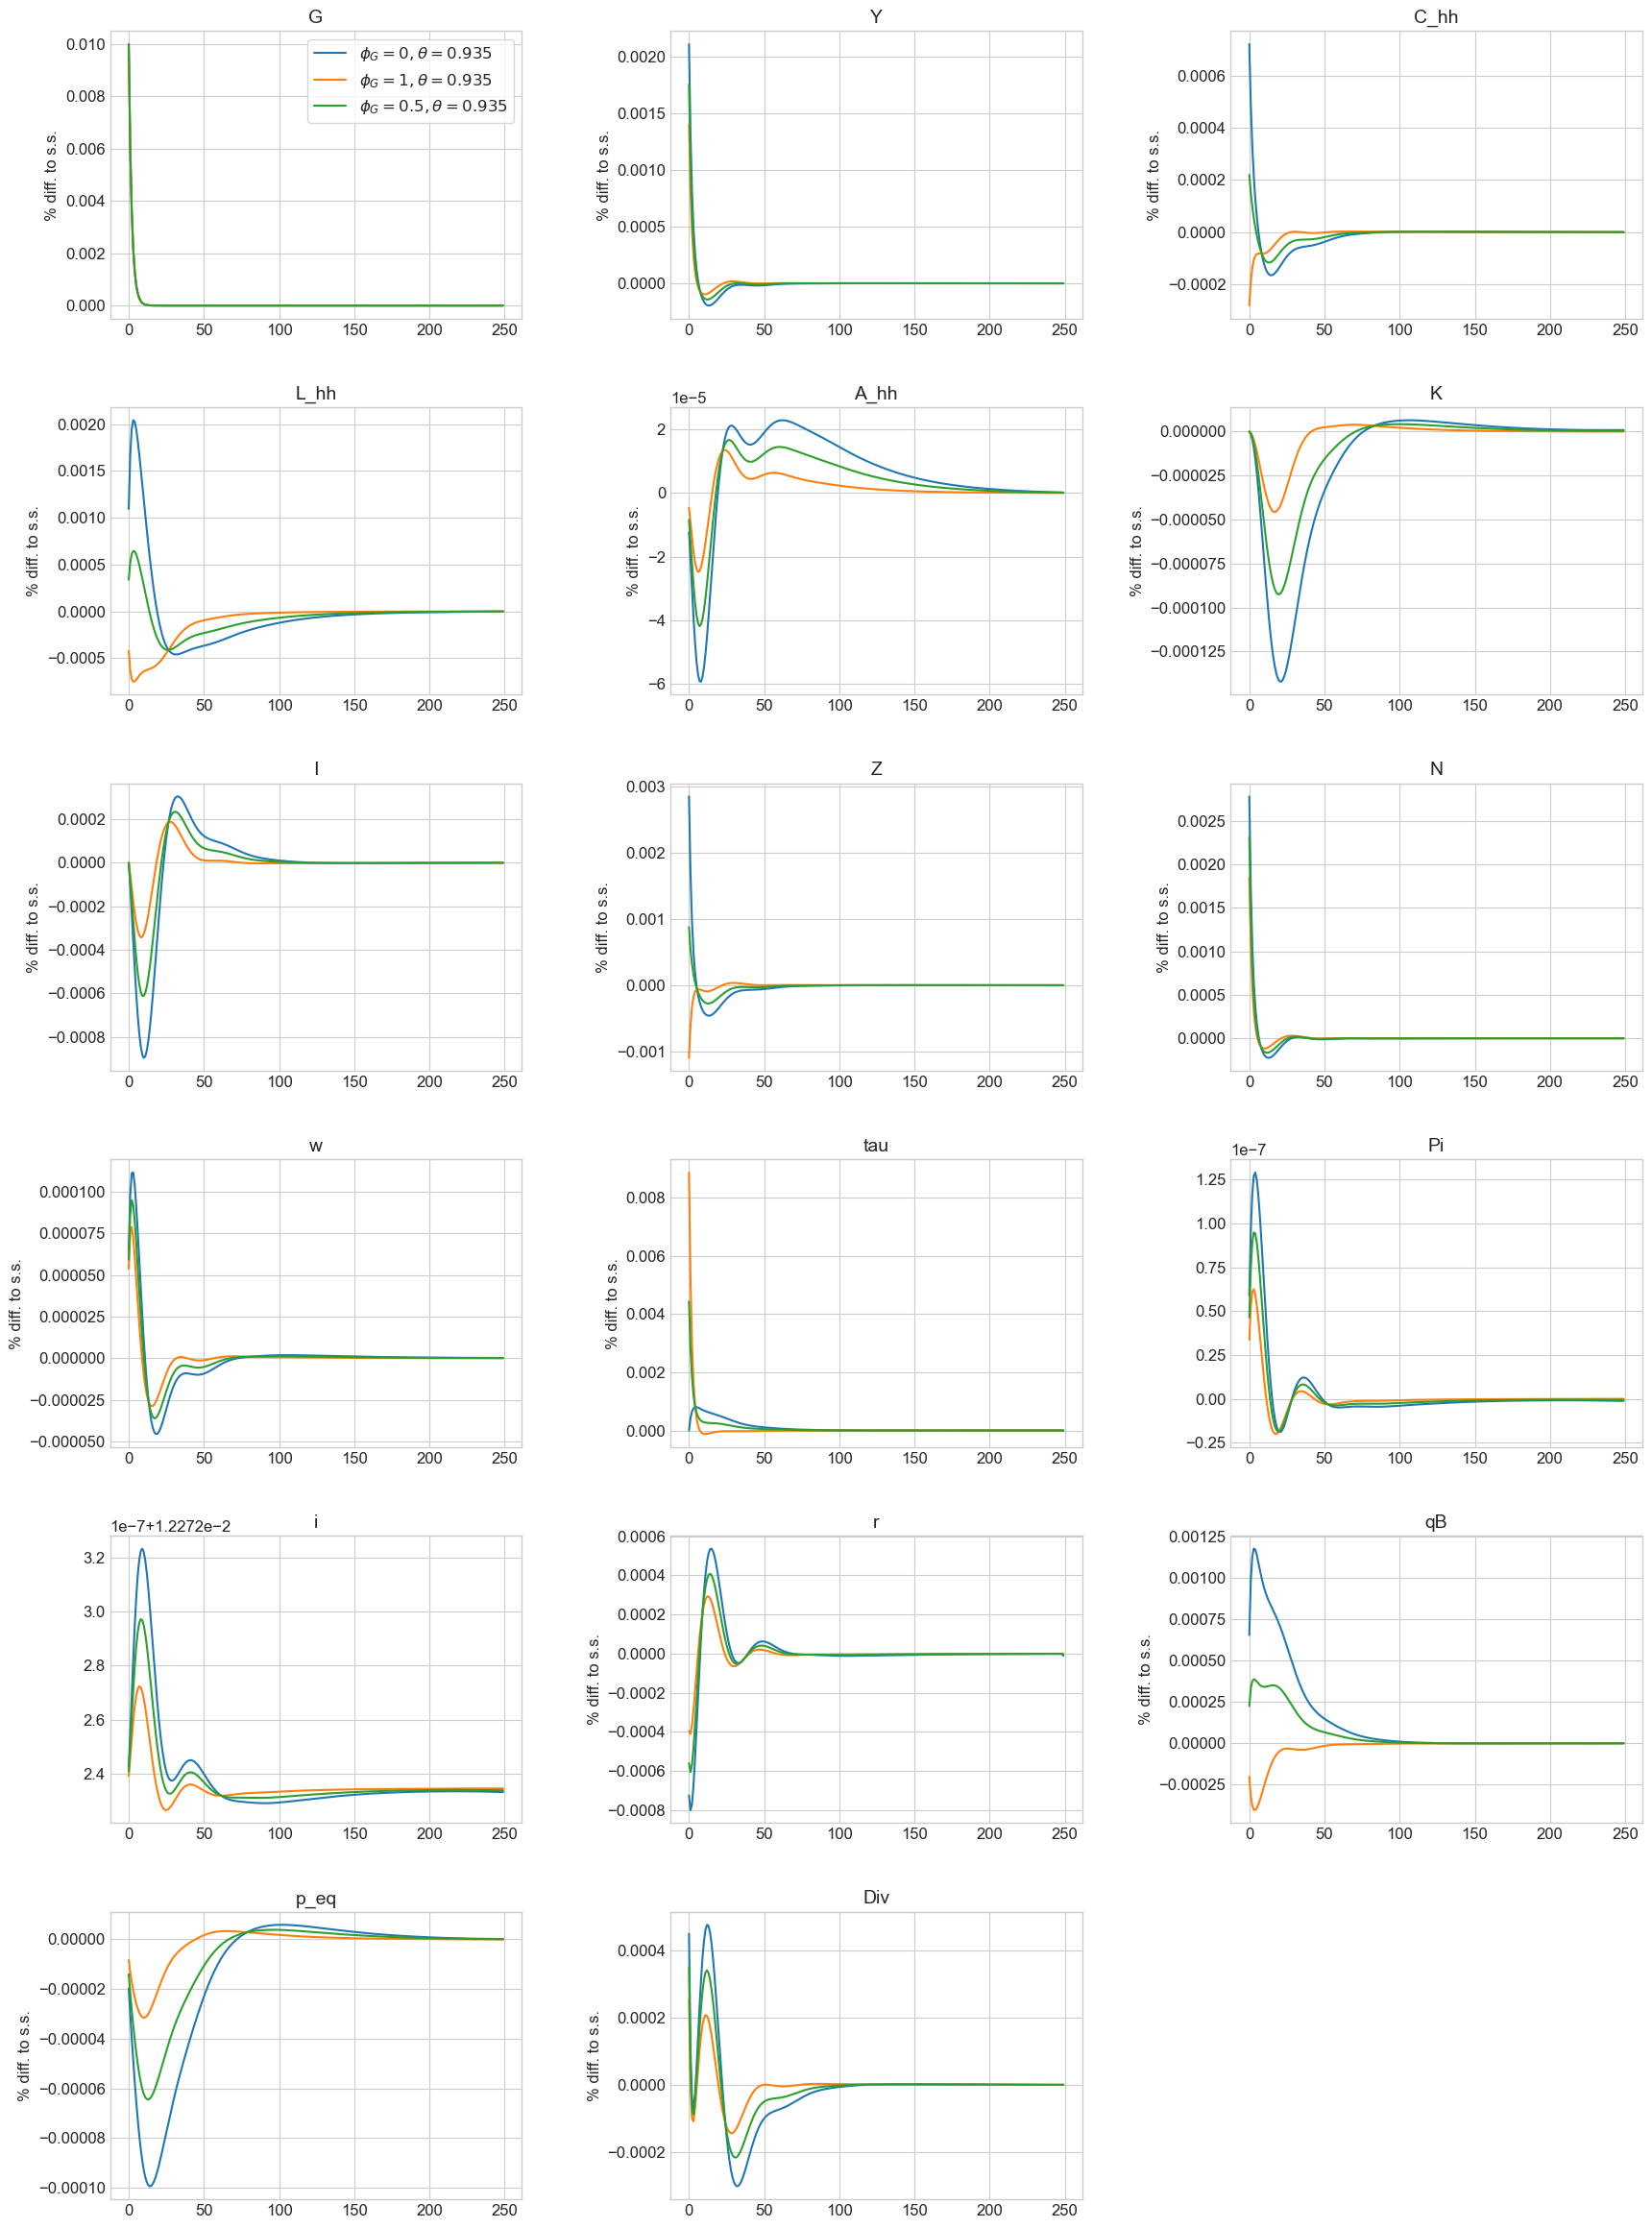

In [113]:
compare_models = ['deficit_financing_sticky', 'deficit_financing_phi_tau_005_sticky', 'deficit_financing_phi_tau_02_sticky']
labels = [f'$\phi_G = 0, \\theta = {baseline_inattention}$', f'$\phi_G = 1, \\theta = {baseline_inattention}$', f'$\phi_G = 0.5, \\theta = {baseline_inattention}$']
models_list = [models_solved[m] for m in compare_models]
models_solved['deficit_financing_sticky'].compare_IRFs(models_list, labels, paths, lvl_value=lvl_value, do_shocks=True, do_targets=False, ncols=3)

In [ ]:
# reset dictionaries to save memory
models = {}
models_solved = {}
model_labels = {}